# Importa bibliotecas

In [195]:
import os
path = os.path.abspath('')
# print(path)
items = os.listdir(path)
if 'Funcoes_GETS.py' not in items:
    ! jupyter nbconvert --to 'python' Funcoes_GETS.ipynb
import Funcoes_GETS as fg

import pandas as pd
import numpy as np
import ipywidgets as widgets
from bqplot import pyplot as bqplt
import bqplot as bq
%matplotlib notebook 

# Carrega banco de dados

In [196]:
equips_data = fg.get_all_equips_data()
OS_data = fg.get_all_OS_data()
OS_data = OS_data.dropna(subset=['Tipo Equip.'])
material_cost_data = fg.load_material_cost_data()
external_cost_data = fg.load_external_cost_data()
# equip_type = np.sort(equips_data['Tipo Equipamento'].unique())
equip_type = np.sort(equips_data['Tipo Equipamento'].unique())

# Gera interface

In [197]:
# np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [264]:
'''###########################
   ####Update data to plot####
   ###########################'''
def update_data(equip,start_date,end_date):
    import pandas as pd
    import numpy as np
    from datetime import date
    today = pd.to_datetime(date.today()).to_numpy()
    if len(equip)==1:
        equip = equip[0]
    available_equips, equip_amount_data, break_data = fg.get_available_equip(equip,equips_data,OS_data)
#     global break_data
#     break_data = breaks
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    x_data1,y_data1,x_data2,y_data2 = fg.arrange_equip_data_to_plot(available_equips,equip_amount_data,start_date,end_date)
    #arrange break_data the same way
    #create time series for break_data
    if break_data.empty==False:
        break_ts = pd.Series(break_data['Taxa de Quebra'].values, index=break_data.index.get_level_values(0))
        #insert last datapoint as today, replicating last known value
        break_ts = break_ts.append(pd.Series(break_ts[-1], index=[today]))
    else:
        print('empty')
        break_ts = pd.DataFrame()
        print(break_ts)
    
    
    #Checks for empty data (necessary to adjust y axis limits)
    empty_flag1,between_two_dates1 = fg.check_for_empty_data(equip_amount_data,start_date,end_date)
    empty_flag2,between_two_dates2 = fg.check_for_empty_data(available_equips,start_date,end_date)
    if empty_flag2==False:
        ymin = np.amin(available_equips[between_two_dates2]['Quantidade Disponível'].values.astype(int))
    else:
        ymin = 0
    if empty_flag1==False:
        ymax = np.amax(equip_amount_data[between_two_dates1]['Quantidade de Equipamentos'].values.astype(int))
    else:
        ymax = np.amax(equip_amount_data['Quantidade de Equipamentos'].values.astype(int))
    return(x_data1,y_data1,x_data2,y_data2,ymin,ymax, break_ts)

def update_data2(equip,start_date,end_date):
    import pandas as pd
    from datetime import date
    today = pd.to_datetime(date.today()).to_numpy()
    if len(equip)==1:
        equip = equip[0]

    available_equips, equip_amount_data, break_data = fg.get_available_equip(equip,equips_data,OS_data)

    material_monthly_cost = fg.get_equip_monthly_cost(equip,material_cost_data)
    external_monthly_cost = fg.get_equip_monthly_cost(equip,external_cost_data)
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    x_data1,y_data1,x_data2,y_data2,x_data3,y_data3 = fg.arrange_cost_data_to_plot(material_monthly_cost,external_monthly_cost,equip_amount_data,start_date,end_date)
    #arrange break_data the same way
    #create time series for break_data
    break_ts = pd.Series(break_data['Taxa de Quebra'].values, index=break_data.index.get_level_values(0))
    #insert last datapoint as today, replicating last known value
    break_ts = break_ts.append(pd.Series(break_ts[-1], index=[today]))
    #Checks for empty data (necessary to adjust y axis limits)
    empty_flag1,between_two_dates1 = fg.check_for_empty_data(equip_amount_data,start_date,end_date)
    empty_flag2,between_two_dates2 = fg.check_for_empty_data(material_monthly_cost,start_date,end_date)
    empty_flag3,between_two_dates3 = fg.check_for_empty_data(external_monthly_cost,start_date,end_date)
    
    if empty_flag1==False:
        ymin = np.amin(equip_amount_data[between_two_dates1]['Quantidade de Equipamentos'].values.astype(int))
        ymax = np.amax(equip_amount_data[between_two_dates1]['Quantidade de Equipamentos'].values.astype(int))
    else:
        ymin = 0
        ymax = np.amax(equip_amount_data['Quantidade de Equipamentos'].values.astype(int))
    
    if selected_analysis.value==1:
        if empty_flag2==False:
            ymax2 = np.amax(material_monthly_cost[between_two_dates2].values)
        else:
            ymax2 = 1
    elif selected_analysis.value==2:
        if empty_flag3==False:
            ymax2 = np.amax(external_monthly_cost[between_two_dates3].values)
        else:
            ymax2 = 1
    else:
        if empty_flag2==False:
            if empty_flag3==False:
                # matches lenghts of x_data2 with x_data3 (add missing dates in x_data and add zeros in missing y_data) 
                i=0
                while x_data3[i] < x_data2[i]:
                    x_data2 = np.insert(x_data2,i,x_data3[i])
                    y_data2 = np.insert(y_data2,0,0)
                    i+=1
                i=0
                while x_data2[i] < x_data3[i]:
                    x_data3 = np.insert(x_data3,i,x_data2[i])
                    y_data3 = np.insert(y_data3,0,0)
                    i+=1
                if len(x_data2)>len(x_data3):
                    y_data3 = np.append(y_data3,np.zeros(len(x_data2)-len(x_data3)))
                    x_data3 = np.append(x_data3,x_data2[len(x_data3):])
                    x_data3 = pd.to_datetime(x_data3)
                elif len(x_data2)<len(x_data3):
                    y_data2 = np.append(y_data2,np.zeros(len(x_data3)-len(x_data2)))
                    x_data2 = np.append(x_data2,x_data3[len(x_data2):])
                    x_data2 = pd.to_datetime(x_data2)
                
                ymax2 = np.amax(np.concatenate((material_monthly_cost[between_two_dates2].values,
                                               external_monthly_cost[between_two_dates3].values)))
            else:
                ymax2 = np.amax(material_monthly_cost[between_two_dates2].values)
        else:
            if empty_flag3==False:
                 ymax2 = np.amax(external_monthly_cost[between_two_dates3].values)
            else:
                ymax2 = 1
    
    
    return(x_data1,y_data1,x_data2,y_data2,x_data3,y_data3,ymin,ymax,ymax2,break_ts)

'''###########################
   #######Create widgets######
   ###########################'''
title = widgets.Label(value="Interface de Análise Temporal do GETS",
                      layout=widgets.Layout(border= '2px solid black',width='100%', display='flex', align_items='center',
                                           justify_content='center'))
tab_titles = ['Quantidade','Custo']
tab = widgets.Tab()
[tab.set_title(i, title) for i, title in enumerate(tab_titles)]
fig = bq.Figure(axes=[])
x_dt = bq.DateScale()
y_sc1 = bq.LinearScale()
def_tt = bq.Tooltip(fields=['x', 'y'], formats=['%d-%b-%y', 'd'],labels=['Data','Quant.'])
scatter1 = bqplt.scatter(x=np.array([0,1]),y=np.array([0,1]),colors=['#ff77ff00'], stroke_width=1, display_legend=False,
                                      scales={'x': x_dt, 'y': y_sc1}, tooltip=def_tt)
scatter2 = bq.Scatter(x=np.array([0,1]),y=np.array([0,1]),colors=['#ff77ff00'], stroke_width=1, display_legend=False,
                                  scales={'x': x_dt, 'y': y_sc1}, tooltip=def_tt)
interp = 'linear'
line1 = bq.Lines(x=np.array([0,1]),y=np.array([0,1]),scales={'x': x_dt, 'y': y_sc1}, display_legend=True, labels=['Ativo'],
                             interpolation=interp, colors=['steelblue'])
line2 = bq.Lines(x=np.array([0,1]),y=np.array([0,1]),scales={'x': x_dt, 'y': y_sc1}, display_legend=True, 
                             labels=['Disponivel'],interpolation=interp, colors=['coral'])
ax_x = bq.Axis(scale=x_dt, label='Data', 
                          tick_style={'stroke': 'black', 'font-size': 12}, tick_format="%b %Y", num_ticks=8)
ax_y1 = bq.Axis(scale=y_sc1, orientation='vertical', label='Quantidade de Equipamentos', 
                           label_style={'stroke': 'black', 'font-size': 12},
                           tick_style={'stroke': 'black', 'font-size': 12},grid_lines='none')
line_forecast = bq.Lines(x=np.array([0,1]),y=np.array([0,1]),scales={'x': x_dt, 'y': y_sc1}, display_legend=True, labels=['Tendência'],
                             interpolation=interp, colors=['darkred'])
line_conf_int = bq.Lines(x=np.array([0,1]),y=[np.array([0,1]),np.array([0,1])],scales={'x': x_dt, 'y': y_sc1}, 
                         display_legend=False, labels=['IC95%','None'],
                         interpolation=interp, colors=['darkred'], fill='between',fill_opacities=[0.2],stroke_width=0)
# print(line_conf_int)
buttonWidth = '60px'
save_data_button = widgets.Button(
    description = 'save',
    tooltip='Save current data',
    icon = 'fa-file-excel-o'
)
save_data_button.layout.width = '90px'
save_button = widgets.Button(
    description = 'Save',
    button_style='success'
)

save_fig_button= widgets.Button(
    description = 'save',
    tooltip='Save current figure',
    icon = 'file-image-o',
)
save_fig_button.layout.width = '90px'
save_fig_button2= widgets.Button(
    description = 'save',
    tooltip='Save current figure',
    icon = 'file-image-o',
)
save_fig_button2.layout.width = '90px'
tb = widgets.HBox(justify_content='center')
fig2 = bq.Figure(axes=[])
y_sc2 = bq.LinearScale()
def_tt2 = bq.Tooltip(fields=['x', 'y'], formats=['%b %Y', '.2f'],labels=['Mês/Ano','Custo'])
bar2 = bq.Bars(x=np.array([0,1]),y=np.array([0,1]), scales={'x': x_dt, 'y': y_sc2},tooltip=def_tt2,display_legend=True, 
                             labels=['Materiais'])

bar3 = bq.Bars(x=np.array([0,1]),y=np.array([0,1]), scales={'x': x_dt, 'y': y_sc2},tooltip=def_tt2,display_legend=True, 
                             labels=['Serviços Externos'])
ax_y2 = bq.Axis(scale=y_sc2, orientation='vertical',  
                            side='right', label_color='seagreen',color='seagreen',label_offset='3.5em',
                           tick_style={'stroke': 'seagreen', 'font-size': 12},grid_lines='dashed',grid_color='seagreen')
bar = bq.Bars(x=np.array([0,1]),y=[np.array([0,1]),np.array([0,1])], scales={'x': x_dt, 'y': y_sc2}, type='grouped',
                              colors=['seagreen','yellowgreen'],tooltip=def_tt2,display_legend=True, 
                             labels=['Materiais','Serviços Externos']) 

tb2 = widgets.HBox(justify_content='center')

fig3 = bq.Figure(animation_duration=1000,legend_text={'font-size': 8}, legend_style={'stroke-width': 0},legend_location = 'top-left')
fig3.max_aspect_ratio = 16/9
fig3.layout.object_fit = 'contain'
# fig3.layout.width = '50%'
fig3.layout.height = '40%'
x_dt3 = bq.DateScale()
y_sc3 = bq.LinearScale()
ax_x3 = bq.Axis(scale=x_dt3, label='Ano',tick_format="%Y")
ax_y3 = bq.Axis(scale=y_sc3, orientation='vertical', label='Custos',label_offset='3.6em',grid_lines='none',
                color='seagreen',label_style={'font-size': 8, 'color': 'seagreen'},tick_style={'color': 'seagreen'})
# scatter3 = bq.Scatter(x=np.array([0,1,2]),y=np.array([0,1,3]), stroke_width=1, display_legend=False,
#                                   scales={'x': x_dt3, 'y': y_sc3})


def display_month_graphic(self, target):
#     print(target)
    if target['event']=='background_click':
        with fig3.hold_sync():
            fig3.axes = []
            fig3.marks = []
            fig3.title = ''
    else:
        if selected_analysis.value==1:
            selected_bar = bar2
            new_labels = ['Materiais']
            new_colors = ['seagreen']
        elif selected_analysis.value==2:
            selected_bar = bar3
            new_labels = ['Serviços Externos']
            new_colors = ['yellowgreen']
        else:
            selected_bar = bar
            new_labels = ['Materiais','Serviços Externos']
            new_colors = ['seagreen','yellowgreen']
        selected_month = pd.DatetimeIndex([selected_bar.x[target['data']['index']]]).month
        selected_year = pd.DatetimeIndex([selected_bar.x[target['data']['index']]]).year
#         print(selected_year)
#         selected_year_index = pd.Series(selected_bar.x).dt.year[pd.Series(selected_bar.x).dt.year==selected_year[0]].index
#         print(selected_year_index)
        month_name = pd.DatetimeIndex([selected_bar.x[target['data']['index']]]).month_name()[0]
        x_series = pd.Series(selected_bar.x)
        selected_month_indexes = x_series.dt.month[x_series.dt.month==selected_month[0]].index
        x_years = pd.to_datetime(x_series[selected_month_indexes].dt.year,format='%Y')
#         print(x_years)
        if selected_analysis.value==3:
            line3 = bq.Lines(x=x_years,
                             y=[selected_bar.y[0][selected_month_indexes],selected_bar.y[1][selected_month_indexes]],
                             stroke_width=1, display_legend=True,
                             scales={'x': x_dt3, 'y': y_sc3},
                             labels=new_labels,colors=new_colors)#,marker = 'circle')
            scatter3 = bq.Scatter(x=x_years,
                                  y=selected_bar.y[0][selected_month_indexes], 
                                  scales={'x': x_dt3, 'y': y_sc3},colors=[new_colors[0]], tooltip = def_tt2)
            scatter4 = bq.Scatter(x=x_years,
                                  y=selected_bar.y[1][selected_month_indexes], 
                                  scales={'x': x_dt3, 'y': y_sc3},colors=[new_colors[1]], tooltip = def_tt2)
            selected_year_idx = x_years.dt.strftime('%Y').tolist().index(str(selected_year[0]))
            scatter4.selected_style={'opacity': 1.0, 'fill': 'DarkOrange', 'stroke': 'Red'}
            scatter4.selected = [selected_year_idx]
#             scatter3 = bq.Lines(x=x_years,
#                              y=[selected_bar.y[0][selected_month_indexes],selected_bar.y[1][selected_month_indexes]],
#                              stroke_width=1, display_legend=True,
#                              scales={'x': x_dt3, 'y': y_sc3},
#                              labels=new_labels,colors=new_colors,marker = 'circle')
            
#             print(selected_month_indexes)
#             print(selected_month_indexes[0])
#             print(np.concatenate(selected_bar.y[0][selected_month_indexes],selected_bar.y[1][selected_month_indexes]).shape)
#             print(np.concatenate(selected_bar.y[0][selected_month_indexes],selected_bar.y[1][selected_month_indexes]))
            ymax = np.amax(np.concatenate((selected_bar.y[0][selected_month_indexes],selected_bar.y[1][selected_month_indexes])))

        else:
            line3 = bq.Lines(x=x_years,y=selected_bar.y[selected_month_indexes], 
                            stroke_width=1, display_legend=True,
                            scales={'x': x_dt3, 'y': y_sc3},
                            labels=new_labels,colors=new_colors)#,marker = 'circle')
            scatter3 = bq.Scatter(x=x_years,y=selected_bar.y[selected_month_indexes], 
                            scales={'x': x_dt3, 'y': y_sc3},
                            colors=new_colors, tooltip = def_tt2)
            ymax = np.amax(selected_bar.y[selected_month_indexes])
#             print(line3.y)
#             print(x_years)
#             print(x_years.dt.strftime('%Y').tolist())
#             print(str(selected_year[0]))
            selected_year_idx = x_years.dt.strftime('%Y').tolist().index(str(selected_year[0]))
#             print(selected_year_idx)
        scatter3.selected_style={'opacity': 1.0, 'fill': 'DarkOrange', 'stroke': 'Red'}
#             scatter3.unselected_style={'opacity': 0.5}
        scatter3.selected = [selected_year_idx]
            
        y_sc3.max = np.around(1.25*ymax)
        fig3.axes = [ax_x3,ax_y3]
        if selected_analysis.value==3:
            fig3.marks = [line3,scatter3,scatter4]
        else:
            fig3.marks = [line3,scatter3]
        fig3.title = month_name
    

bar2.on_element_click(display_month_graphic)
bar3.on_element_click(display_month_graphic)
bar.on_element_click(display_month_graphic)
bar2.on_background_click(display_month_graphic)
bar3.on_background_click(display_month_graphic)
bar.on_background_click(display_month_graphic)

file_types = [('.csv',1), ('.xls',2),('.txt',3)]
selected_file_type = widgets.Dropdown(
    options=file_types,
    value=1,
    description='Tipo:',
    disabled=False,
)

selected_equips = widgets.Combobox(
    options=equip_type.tolist(),
    placeholder='Ex: VENTILADOR UTI',
    value='',
    ensure_option=True,
    disabled=False
)

label1 = widgets.Label(value="Tipo de Medida:")
label2 = widgets.Label(value="Equipamento:")
label3 = widgets.Label(value="Data Inicial:")
label4 = widgets.Label(value="Data Final:")
label5 = widgets.Label(value="Mostrar Tendência?")
label6 = widgets.Label(value="Prever a partir de:",layout=widgets.Layout(visibility='hidden'))
label7 = widgets.Label(value="por ",layout=widgets.Layout(flex='1 0 auto', width='auto',visibility='hidden'))
label8 = widgets.Label(value="semanas",layout=widgets.Layout(flex='1 0 auto', width='auto',visibility='hidden'))
error_msg = ''
error_label = widgets.Label(value= '')

analysis_types = [('Custo Total de Material/Mes',1), ('Custo Total de Serviço Externo/Mes',2),('Custos Totais/Mes',3)]
selected_analysis = widgets.Dropdown(
    options=analysis_types,
    value=3,
    description='',
    disabled=False,
)

tendency = widgets.Checkbox(
    value=False,
    description='Mostrar linha de tendência',
    disabled=False,
    indent=False
)
selected_start_date = widgets.DatePicker(
    description='',
    disabled=False,
    value=pd.to_datetime('2013-01-01')
)
selected_end_date = widgets.DatePicker(
    description='',
    disabled=False,
    value=pd.to_datetime('2020-09-01')
)
selected_tendency_start_date = widgets.DatePicker(
    description='',
    disabled=False,
    value=pd.to_datetime('2020-01-01'),
    layout=widgets.Layout(visibility='hidden')
)
prediction_range = widgets.BoundedIntText(
    value=52,
    min=1,
    max=104,
    step=1,
    description='',
    disabled=False,
    layout=widgets.Layout(flex='0 1 auto', width='auto',visibility='hidden')
)

'''###########################
   ####Create file chooser####
   ###########################'''
from ipyfilechooser import FileChooser
# Create and display a FileChooser widget
fc = FileChooser(os.path.abspath(os.getcwd()))
# Show or hide folder icons
fc.use_dir_icons = True
# # Switch to folder-only mode
# fc.show_only_dirs = True
fc.default_filename = selected_equips.value + ' output'
# Change the title (use '' to hide)
fc.title = 'Salvar como...'

data_type_and_save_box = widgets.HBox([selected_file_type,save_button])
save_box = widgets.VBox([fc,data_type_and_save_box])

'''###########################
   ######Create toolbars######
   ###########################'''

'''########Toolbar 1########'''
from bqplot.interacts import PanZoom
from traitlets import link
from collections import OrderedDict

pz = PanZoom()
pzx = PanZoom()
pzy = PanZoom()

zoom_interacts = widgets.ToggleButtons(
                                        options=OrderedDict([
                                            ('xy ', pz), 
                                            ('x ', pzx), 
                                            ('y ', pzy),   
                                            (' ', None)]),
                                            icons = ["arrows", "arrows-h", "arrows-v", "stop"],
                                            tooltips = ["zoom/pan in x & y", "zoom/pan in x only", "zoom/pan in y only", "cancel zoom/pan"]
                                        )
zoom_interacts.style.button_width = buttonWidth
ResetZoomButton = widgets.Button(
    description='',
    disabled=False,
    button_style='',
    tooltip='Reset zoom',
    icon='refresh'
)

global ymin, ymax, ymax2
ymin = 0
ymax = 1
ymax2 = 1
def resetZoom(new):
    # Reset the x and y axes on the figure
    fig.axes[0].scale.min = selected_start_date.value
    fig.axes[1].scale.min = float(ymin)
    fig.axes[0].scale.max = selected_end_date.value
    fig.axes[1].scale.max = float(ymax)

ResetZoomButton.on_click(resetZoom)
ResetZoomButton.layout.width = buttonWidth

l = link((zoom_interacts, 'value'), (fig, 'interaction'))

'''########Toolbar 2########'''
pz2 = PanZoom()
pzx2 = PanZoom()
pzy2 = PanZoom()

zoom_interacts2 = widgets.ToggleButtons(
                                        options=OrderedDict([
                                            ('xy ', pz2), 
                                            ('x ', pzx2), 
                                            ('y ', pzy2),   
                                            (' ', None)]),
                                            icons = ["arrows", "arrows-h", "arrows-v", "stop"],
                                            tooltips = ["zoom/pan in x & y", "zoom/pan in x only", "zoom/pan in y only", "cancel zoom/pan"]
                                        )
zoom_interacts2.style.button_width = buttonWidth
ResetZoomButton2 = widgets.Button(
    description='',
    disabled=False,
    button_style='',
    tooltip='Reset zoom',
    icon='refresh'
)

def resetZoom2(new):
    # Reset the x and y axes on the figure
    fig2.axes[0].scale.min = selected_start_date.value
    fig2.axes[1].scale.min = float(ymin)
    fig2.axes[0].scale.max = selected_end_date.value
    fig2.axes[1].scale.max = float(ymax)
    fig2.axes[2].scale.min = 0
    fig2.axes[2].scale.max = float(ymax2)

ResetZoomButton2.on_click(resetZoom2)
ResetZoomButton2.layout.width = buttonWidth

link((zoom_interacts2, 'value'), (fig2, 'interaction'))

'''###############################################################
   ####callback function to handle any change in the interface####
   ###############################################################'''
def build_forecast(ts,end_train_date):
    from statsmodels.tsa.arima.model import ARIMA
    ts_train = ts[ts.index<end_train_date]
    model = ARIMA(ts_train, order=(3,0,2))
    model_fit = model.fit()
    return(model_fit)
def on_change(b):
    error_label.value = ''
    if selected_start_date.value==None:
        error_msg = 'Por \ favor \ selecione \ uma \ data \ inicial!'
        error_label.value = r'\(\color{red} {' + error_msg + '}\)'
    elif selected_end_date.value==None:
        error_msg = 'Por \ favor \ selecione \ uma \ data \ final!'
        error_label.value = r'\(\color{red} {' + error_msg + '}\)'
    elif selected_equips.value=='':
        error_msg = 'Por \ favor \ selecione \ um \ equipamento!'
        error_label.value = r'\(\color{red} {' + error_msg + '}\)'
    else:
        bar2.selected = []
        bar3.selected = []
        bar.selected = []
        fig3.axes = []
        fig3.marks = []
        fig3.title = ''
        global ymin, ymax, ymax2
        if tab.selected_index==0:
            x_data1,y_data1,x_data2,y_data2,ymin,ymax,break_ts = update_data(selected_equips.value,selected_start_date.value,selected_end_date.value)
            if tendency.value==True:
                label6.layout.visibility='visible'
                label7.layout.visibility='visible'
                label8.layout.visibility='visible'
                prediction_range.layout.visibility='visible'
                selected_tendency_start_date.layout.visibility='visible'
                global yo2, xo2, yo1, xo1, xo3, yo3, ts3, ts1
                ts2 = pd.Series(y_data2, index=x_data2)
                ts2 = ts2.groupby(pd.Grouper(freq="W")).last().fillna(method='ffill')
                xo2 = ts2.index
                yo2 = ts2.values
                x_data2 = xo2 #temp
                y_data2 = yo2 #temp
                ts1 = pd.Series(y_data1, index=x_data1)
                ts1 = ts1.groupby(pd.Grouper(freq="W")).last().fillna(method='ffill')
                xo1 = ts1.index
                yo1 = ts1.values
                if break_ts.empty==False:
                    ts3 = break_ts.groupby(pd.Grouper(freq="W")).last().fillna(method='ffill')
                    xo3 = ts3.index
                    yo3 = ts3.values
                    #convert to timestamp
                    tendency_start_date = pd.Timestamp(selected_tendency_start_date.value)
                    #build a model using training data previous to tendency_start_date
                    model_fit = build_forecast(ts3,tendency_start_date)
                    
                    # predict values from built model for (at first) q year (52weeks) before and after tendency_start_date
                    time_delta = pd.to_timedelta(int(prediction_range.value),'W')
                    #arranges prediction start to a sunday (since working with weeks)
                    prediction_starting_week = tendency_start_date + pd.to_timedelta(6-tendency_start_date.dayofweek, unit='d')
                    prediction_start = prediction_starting_week
                    prediction_end = prediction_starting_week
                    prediction_start -= time_delta
                    prediction_end += time_delta
                    # make predictions (using ".predict" here because it can generate in_sample data)
                    prediction = model_fit.predict(prediction_start.strftime('%Y-%m-%d'),
                                                   prediction_end.strftime('%Y-%m-%d'), dynamic=False)
                    #Find index of ts1 (blue curve) where it macthes tendency_start_date (rounded to week sunday)
                    idx_ts1 = np.argwhere(ts1.index==prediction_starting_week)[0][0]
                    #Find same index of prediction vector 
                    idx_prediction = np.argwhere(prediction.index==prediction_starting_week)[0][0]
                    ### Arrange prediction (based on break rate) to match orange curve (available equips)###
                    # Prediction values until the end of ts1 receive corresponding ts1 values minus prediction values 
                    prediction.values[:idx_prediction] = ts1.values[idx_ts1-idx_prediction:idx_ts1] - prediction.values[:idx_prediction]
                    # Prediction values beyond ts1 receive ts1 "last value" (equivalent to tendency_start_date) minus prediction values
                    prediction.values[idx_prediction:] = ts1.values[idx_ts1] - prediction.values[idx_prediction:]
                    
                    # number of weeks to forecast conf intervals
                    n_forecast = int(prediction_range.value)
                     # generate forecast (here we use ".forecast" instead of ".predict" because it can generate confidence intervals)
                    forecast = model_fit.get_forecast(n_forecast)
                    # get conf intervals for generated forecast
                    conf_int = forecast.conf_int()
                    # Arrnage confidence intervals the same way as predictions to match available equips curve (orange curve)
                    conf_int = ts1.values[idx_ts1] - conf_int
                    
                    line_conf_int.x = conf_int.index
                    line_conf_int.y = [conf_int.iloc[:,0].values,conf_int.iloc[:,1].values]
                    line_forecast.x = prediction.index
                    line_forecast.y = prediction.values
            else:
                label6.layout.visibility='hidden'
                label7.layout.visibility='hidden'
                label8.layout.visibility='hidden'
                prediction_range.layout.visibility='hidden'
                selected_tendency_start_date.layout.visibility='hidden'
            with scatter1.hold_sync():
                scatter1.x = x_data1
                scatter1.y = y_data1
            with line1.hold_sync():
                line1.x = x_data1
                line1.y = y_data1
                line1.fill = 'bottom'
                line1.marker = 'square'
                line1.marker_size = 20
                line1.fill_opacities = [0.2]
            with scatter2.hold_sync():
                scatter2.x = x_data2
                scatter2.y = y_data2
            with line2.hold_sync():
                line2.x = x_data2
                line2.y = y_data2
                line2.fill = 'bottom'
                line2.marker = 'circle'
                line2.fill_opacities = [0.2]
#                 line2.colors = ['DarkOrange']
                line2.marker_size = 8
                line2.opacities = [.5]
            x_dt.min = pd.to_datetime(selected_start_date.value)
            x_dt.max = pd.to_datetime(selected_end_date.value)
            if (pd.to_datetime(selected_end_date.value) - pd.to_datetime(selected_start_date.value)).days<240:
                ax_x.tick_format = "%d-%b-%y"
            with y_sc1.hold_sync():
                y_sc1.min = np.around(0.9*ymin)
                y_sc1.max = np.around(1.1*ymax)
            with ax_y1.hold_sync():
                ax_y1.label_color='black'
                ax_y1.color='black'
                ax_y1.tick_style={'stroke': 'black', 'font-size': 12}
                ax_y1.grid_color='black'    
            if (tendency.value==True) & (break_ts.empty==False):
                fig.marks = [line1,line2,line_forecast,line_conf_int,scatter1,scatter2]
            else:
                print(tendency.value)
                print(break_ts.empty)
                fig.marks = [line1,line2,scatter1,scatter2]
            fig.axes = [ax_x, ax_y1]
            fig.legend_location = 'top-left'
            pz.scales={'x': [x_dt], 'y': [y_sc1]}
            pzx.scales={'x': [x_dt]}
            pzy.scales={'y': [y_sc1], }
            tb.children = ()
            tb.children += (widgets.HBox([zoom_interacts,ResetZoomButton,save_data_button,save_fig_button]),)
            tb.layout.justify_content = 'center'  
        else:
            x_data1,y_data1,x_data2,y_data2,x_data3,y_data3,ymin,ymax,ymax2,break_ts = update_data2(selected_equips.value,
                                                                                           selected_start_date.value,
                                                                                           selected_end_date.value)
            with scatter1.hold_sync():
                scatter1.x = x_data1
                scatter1.y = y_data1
            with line1.hold_sync():
                line1.x = x_data1
                line1.y = y_data1
                line1.fill = 'bottom'
                line1.marker = 'square'
                line1.marker_size = 20
                line1.fill_opacities = [0.2]
            with bar2.hold_sync():
                bar2.x = x_data2
                bar2.y = y_data2
                bar2.colors = ['seagreen']
                bar2.interactions = {
                    'legend_hover': 'highlight_axes',
                    'hover': 'tooltip',
                    'click':'select'
                }
                bar2.selected_style={'opacity': 1.0, 'fill': 'DarkOrange', 'stroke': 'Red'}
                bar2.unselected_style={'opacity': 0.5}
#                 bar2.opacities = [0.5]
            with bar3.hold_sync():
                bar3.x = x_data3
                bar3.y = y_data3
                bar3.colors = ['yellowgreen']
#                 bar3.opacities = [0.5]
                bar3.interactions = {
                    'legend_hover': 'highlight_axes',
                    'hover': 'tooltip',
                    'click':'select'
                }
                bar3.selected_style={'opacity': 1.0, 'fill': 'DarkOrange', 'stroke': 'Red'}
                bar3.unselected_style={'opacity': 0.5}
            with x_dt.hold_sync():
                x_dt.min = pd.to_datetime(selected_start_date.value)
                x_dt.max = pd.to_datetime(selected_end_date.value)
            if (pd.to_datetime(selected_end_date.value) - pd.to_datetime(selected_start_date.value)).days<240:
                ax_x.tick_format = "%d-%b-%y"
            with y_sc1.hold_sync():
                y_sc1.min = np.around(0.9*ymin)
                y_sc1.max = np.around(1.1*ymax)
            with y_sc2.hold_sync():
                y_sc2.min = 0
                y_sc2.max = 1.1*ymax2   
            if selected_analysis.value==1:
                fig2.marks = [line1,bar2,scatter1]
            elif selected_analysis.value==2:
                fig2.marks = [line1,bar3,scatter1]
            else:
                with bar.hold_sync():
                    bar.x = x_data2
                    bar.y = [y_data2, y_data3]
#                     bar.opacities = [0.5, 0.5]
                    bar.interactions = {
                        'legend_hover': 'highlight_axes',
                        'hover': 'tooltip',
                        'click':'select'
                    }
                    bar.selected_style={'opacity': 1.0, 'fill': 'DarkOrange', 'stroke': 'Red'}
                    bar.unselected_style={'opacity': 0.5}
                fig2.marks = [line1,bar,scatter1]
            
            ax_y2.label=selected_analysis.label
            with ax_y1.hold_sync():
                ax_y1.label_color='steelblue'
                ax_y1.color='steelblue'
                ax_y1.tick_style={'stroke': 'steelblue', 'font-size': 12}
                ax_y1.grid_color='steelblue'
            
            
            fig2.axes = [ax_x,ax_y1,ax_y2]
            fig2.legend_location = 'top-left'
            pz2.scales={'x': [x_dt], 'y': [y_sc1,y_sc2]}
            pzx2.scales={'x': [x_dt]}
            pzy2.scales={'y': [y_sc1,y_sc2], }
            tb2.children = ()
            tb2.children += (widgets.HBox([zoom_interacts2,ResetZoomButton2,save_data_button,save_fig_button2]),)
            tb2.layout.justify_content = 'center'
            
# def show_tendency(b):
#     a=1
#     print(b)
    
'''######################################
   ####Functions to save data and fig####
   ######################################'''
# Opens filechooser interface
def on_save_data(b):
    error_label.value = ''
    if selected_start_date.value==None:
        error_msg = 'Por \ favor \ selecione \ uma \ data \ inicial!'
        error_label.value = r'\(\color{red} {' + error_msg + '}\)'
    elif selected_end_date.value==None:
        error_msg = 'Por \ favor \ selecione \ uma \ data \ final!'
        error_label.value = r'\(\color{red} {' + error_msg + '}\)'
    elif selected_equips.value=='':
        error_msg = 'Por \ favor \ selecione \ um \ equipamento!'
        error_label.value = r'\(\color{red} {' + error_msg + '}\)'
    else:
        save_box.layout.visibility = 'visible'
# Saves figure
def on_save_figure(b):
    error_label.value = ''
    if tab.selected_index==0:
        fig_file_name = selected_equips.value + ' Ativos DE ' + selected_start_date.value.strftime('%Y-%m-%d') + ' A ' + selected_end_date.value.strftime('%Y-%m-%d')
        fig.save_png(fig_file_name)
    else:
        fig_file_name2 = selected_equips.value + ' Custos DE ' + selected_start_date.value.strftime('%Y-%m-%d') + ' A ' + selected_end_date.value.strftime('%Y-%m-%d')
        print(fig_file_name2)
        fig2.save_png(fig_file_name2)
    
# Save whole data in specified directory with chosen format    
def on_save(b):
    error_label.value = ''
    if fc.selected==None:
        error_msg = 'Por \ favor \ selecione \ uma \ pasta!'
        error_label.value = r'\(\color{red} {' + error_msg + '}\)'
    else:
        global ymin, ymax, ymax2
        if tab.selected_index==0:
            x_data1,y_data1,x_data2,y_data2,ymin,ymax,break_ts = update_data(selected_equips.value,selected_start_date.value,selected_end_date.value)
            d = {'Datas': x_data2, 'Disponivel': y_data2}
            df1 = pd.DataFrame(data=d)
            d = {'Datas2': x_data1, 'Ativos': y_data1}
            df2 = pd.DataFrame(data=d)
            df = pd.concat([df1,df2],axis=1)

            filepath = os.path.join(fc.selected_path,fc.selected_filename)

            if selected_file_type.value==1:
                file = filepath + '.csv'
                df.to_csv(file, index=False)
            elif selected_file_type.value==2:
                file = filepath + '.xls'
                df.to_excel(file, index=False)
            else:
                file = filepath + '.txt'
                df.loc[:,'Datas'] = df.loc[:,'Datas'].dt.strftime('%d/%m/%Y')
                df.loc[:,'Datas2'] = df.loc[:,'Datas2'].dt.strftime('%d/%m/%Y')
                df.fillna('', inplace=True)
                np.savetxt(file, df.values, fmt='%s',header='Data\tDisponivel\tData2\tAtivo')
            save_box.layout.visibility = 'hidden'
        else:
            x_data1,y_data1,x_data2,y_data2,x_data3,y_data3,ymin,ymax,ymax2,break_ts = update_data2(selected_equips.value,
                                                                                           selected_start_date.value,
                                                                                           selected_end_date.value)
            d = {'Datas': x_data1, 'Ativos': y_data1}
            df1 = pd.DataFrame(data=d)
            d = {'Datas2': x_data2, 'Custo de Material': y_data2}
            df2 = pd.DataFrame(data=d)
            d = {'Datas3': x_data3, 'Custo de Servico Externo': y_data3}
            df3 = pd.DataFrame(data=d)
            df = pd.concat([df1,df2,df3],axis=1)

            filepath = os.path.join(fc.selected_path,fc.selected_filename)

            if selected_file_type.value==1:
                file = filepath + '.csv'
                df.to_csv(file, index=False)
            elif selected_file_type.value==2:
                file = filepath + '.xls'
                df.to_excel(file, index=False)
            else:
                file = filepath + '.txt'
                df.loc[:,'Datas'] = df.loc[:,'Datas'].dt.strftime('%d/%m/%Y')
                df.loc[:,'Datas2'] = df.loc[:,'Datas2'].dt.strftime('%d/%m/%Y')
                df.loc[:,'Datas3'] = df.loc[:,'Datas3'].dt.strftime('%d/%m/%Y')
                df.fillna('', inplace=True)
                np.savetxt(file, df.values, fmt='%s',header='Datas\tAtivos\tDatas2\tCusto de Material\tDatas3\tCusto de Servico Externo')
            save_box.layout.visibility = 'hidden'

'''######################################
   #######Link widgets to callbacks######
   ######################################'''
selected_analysis.observe(on_change,names='value')
selected_equips.observe(on_change,names='value')
selected_start_date.observe(on_change,names='value')
selected_end_date.observe(on_change,names='value')
tab.observe(on_change,names='selected_index')
save_data_button.on_click(on_save_data)
save_button.on_click(on_save)
save_fig_button.on_click(on_save_figure)
save_fig_button2.on_click(on_save_figure)
tendency.observe(on_change,type='change')
selected_tendency_start_date.observe(on_change,names='value')
prediction_range.observe(on_change,names='value')

'''#################################
   #######Build main interface######
   #################################'''
vbox = widgets.VBox([label2,
              selected_equips,
              label3,
              selected_start_date,
              label4,
              selected_end_date,
              tendency,
              label6,
              selected_tendency_start_date,
              widgets.HBox([label7,prediction_range,label8],layout=widgets.Layout(align_self='flex-start')),
              error_label
             ])

vbox2 = widgets.VBox([label1,
              selected_analysis,
              label2,
              selected_equips,
              label3,
              selected_start_date,
              label4,
              selected_end_date,
#               button_plot,
              error_label,
              fig3
             ])

vbox_fig = widgets.VBox([fig,tb,save_box], align_self='stretch',justify_content='center')
vbox_fig2 = widgets.VBox([fig2,tb2,save_box], align_self='stretch')#,layout=center_layout)
save_box.layout.visibility = 'hidden'

app = widgets.AppLayout(header=None,
          left_sidebar=vbox,
          center=vbox_fig,
          right_sidebar=None,
          footer=None,
          pane_widths=[2, 4, 0],
          pane_heights=[0,9,0],
          layout=widgets.Layout(border= ''))

app2 = widgets.AppLayout(header=None,
          left_sidebar=vbox2,
          center=vbox_fig2,
          right_sidebar=None,
          footer=None,
          pane_widths=[2, 4, 0],
          pane_heights=[0,9,0],
          layout=widgets.Layout(border= ''))

children = [app,app2]
tab.children = children

header = widgets.HBox()
header.children = [title]

main_app = widgets.VBox([header,tab])
main_app

False
False
False
False
MONITOR FISIOLOGICO MULTIUSO Custos DE 2013-01-01 A 2020-09-01
False
False
False
False


In [260]:
xo3[xo3>'2016-12-30']

DatetimeIndex(['2017-01-01', '2017-01-08', '2017-01-15', '2017-01-22',
               '2017-01-29', '2017-02-05', '2017-02-12', '2017-02-19',
               '2017-02-26', '2017-03-05',
               ...
               '2020-10-04', '2020-10-11', '2020-10-18', '2020-10-25',
               '2020-11-01', '2020-11-08', '2020-11-15', '2020-11-22',
               '2020-11-29', '2020-12-06'],
              dtype='datetime64[ns]', length=206, freq='W-SUN')

In [243]:
ano = pd.to_datetime('2017') + pd.to_timedelta(6-pd.to_datetime('2017').dayofweek, unit='d')

In [236]:
6-pd.to_datetime('2020').dayofweek

4

In [244]:
ano

Timestamp('2017-01-01 00:00:00')

In [230]:
ano_delta = pd.to_timedelta(52,'W')

In [231]:
ano_inicio = pd.to_datetime(ano-ano_delta)

In [232]:
ano_inicio

Timestamp('2018-12-31 00:00:00')

In [226]:
pd.to_timedelta(ano_inicio.dayofweek, unit='d')

Timedelta('2 days 00:00:00')

In [225]:
ano_inicio - pd.to_timedelta(ano_inicio.dayofweek, unit='d')

Timestamp('2018-12-31 00:00:00')

In [178]:
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt
# plt.scatter(yo3,yo1[xo1>=xo3[0]])
# print(np.corrcoef(yo3, yo1[xo1>=xo3[0]]))
# print(ts3.corr(ts1[ts1.index>=xo3[0]], method='pearson'))
# print(ts3.corr(ts1[ts1.index>=xo3[0]], method='spearman'))

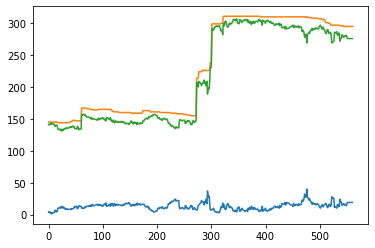

In [92]:
plt.plot(yo3)
plt.plot(yo1[xo1>'03-2010'])
plt.plot(yo1[xo1>'03-2010'][:-1]-yo3)

In [141]:
np.argwhere(xo1>pd.to_datetime(2020, format='%Y'))[0][0]

2125

In [142]:
xo1[2125]

Timestamp('2020-01-05 00:00:00', freq='W-SUN')

In [137]:
pd.to_datetime(2020, format='%Y')

Timestamp('2020-01-01 00:00:00')

In [8]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Plot time series (training subset)

In [9]:
ts3_train = ts3[ts3.index<'2020']

<AxesSubplot:>

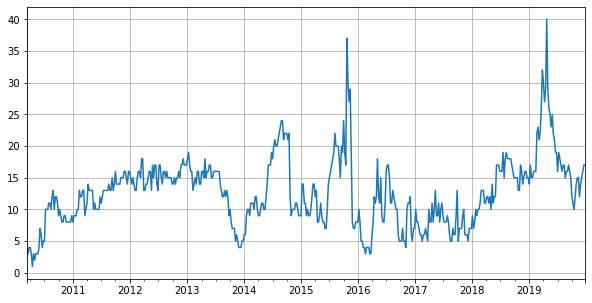

In [10]:
ts3_train.plot(figsize=[10,5],grid=True)

## test for stationarity KPSS

In [11]:
from statsmodels.tsa.stattools import kpss
kpss_results = kpss(ts3_train,nlags='auto')#,regression='ct')

Z:\anaconda3\envs\GETS_env3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [12]:
print('KPSS statistic=',kpss_results[0])
print('P-value=',kpss_results[1])
print('lags=',kpss_results[2])

KPSS statistic= 0.2755050451392382
P-value= 0.1
lags= 12


## Differentiate time series (if it has cycle, season or trend, i.e., if it is not stationary)

In [13]:
ts3_train_d1 = ts3_train.diff()[~np.isnan(ts3_train.diff().values)]

<AxesSubplot:>

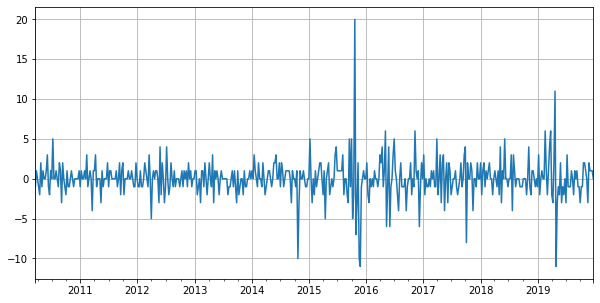

In [14]:
ts3_train_d1.plot(figsize=[10,5],grid=True)

## Plot autocorrelation function and partial acf

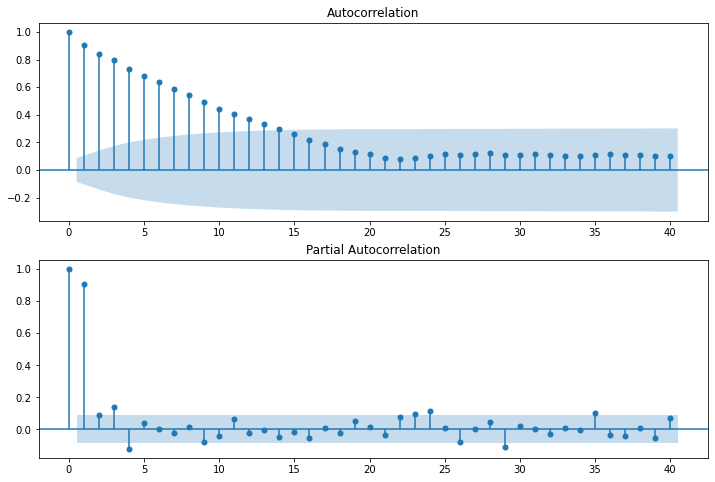

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts3_train.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts3_train, lags=40, ax=ax2)

### Based on acf and pacf, build a model

In [17]:
arima_model = ARIMA(ts3_train, order=(3, 0, 2))
# arma_mod012 = SARIMAX(ts3_train, order=(3, 0, 2),seasonal_order=(1, 0, 0, 13))
arima_model_fit = arima_model.fit()
print(arima_model_fit.params)

const     12.560507
ar.L1      0.038371
ar.L2      0.242848
ar.L3      0.550413
ma.L1      0.807533
ma.L2      0.411368
sigma2     4.824293
dtype: float64


### Print model errors (AIC, BIC, HQIC)

In [18]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  512
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -1130.332
Date:                Wed, 02 Dec 2020   AIC                           2274.665
Time:                        08:59:50   BIC                           2304.333
Sample:                    03-14-2010   HQIC                          2286.295
                         - 12-29-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5605      1.375      9.133      0.000       9.865      15.256
ar.L1          0.0384      0.123      0.312      0.755      -0.203       0.280
ar.L2          0.2428      0.081      2.984      0.003       0.083       0.402
ar.L3          0.5504      0.133      4.138      0.000       0.290       0.811
ma.L1          0.8075      0.136      5.923      0.000       0.540       1.075
ma.L2          0.4114      0.157      2.620      0.009       0.104       0.719
sigma2         4.8243      0.146     32.970      0.000       4.538       5.111
===================================================================================
Ljung-Box (Q):                       45.37   Jarque-Bera (JB):              4683.34
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               2.60   Skew:                             1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Check model for serial correlation

Durbin Watson test for serial correlation (if close to 2, no serial correlation)

In [19]:
sm.stats.durbin_watson(arima_model_fit.resid.values)

1.987351384521076

## Residual analysis

### Plot the residues

In [21]:
resid = arima_model_fit.resid

In [30]:
resid.index

DatetimeIndex(['2010-03-14', '2010-03-21', '2010-03-28', '2010-04-04',
               '2010-04-11', '2010-04-18', '2010-04-25', '2010-05-02',
               '2010-05-09', '2010-05-16',
               ...
               '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17',
               '2019-11-24', '2019-12-01', '2019-12-08', '2019-12-15',
               '2019-12-22', '2019-12-29'],
              dtype='datetime64[ns]', length=512, freq='W-SUN')

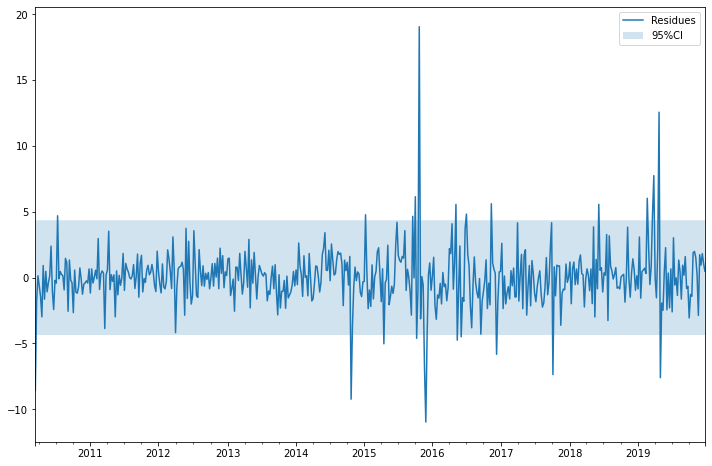

In [40]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arima_model_fit.resid.plot(ax=ax,label='Residues')
resid_std = np.std(resid)
plt.fill_between(resid.index,-np.ones(resid.shape)*resid_std*1.96,np.ones(resid.shape)*resid_std*1.96,alpha=0.2,label='95%CI')
plt.legend()

(array([0.00195127, 0.00325211, 0.03317151, 0.21854172, 0.06504218,
        0.0091059 , 0.00065042, 0.00065042, 0.        , 0.00065042]),
 array([-10.96843781,  -7.96557861,  -4.96271941,  -1.95986021,
          1.04299899,   4.04585818,   7.04871738,  10.05157658,
         13.05443578,  16.05729498,  19.06015418]),
 <BarContainer object of 10 artists>)

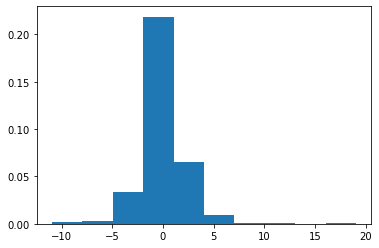

In [41]:
plt.hist(resid,density=True)

### Test for normality of residues

In [42]:
stats.normaltest(resid) #D’Agostino and Pearson’s test, if p<0.05: not normal dist

NormaltestResult(statistic=196.2488825544923, pvalue=2.4271499805003312e-43)

Do residuals arise from a standard normal distribution?

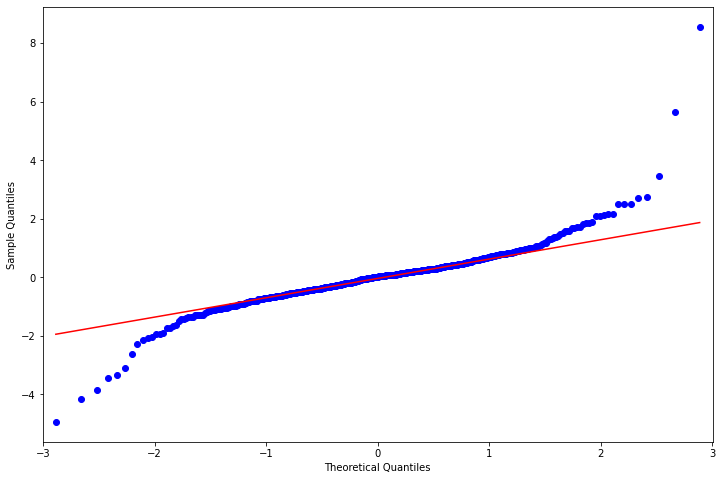

In [43]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

### Test autocorrelation of residues: Ljung-Box test for autocorrelation 

In [44]:
sm.stats.acorr_ljungbox(resid, lags=10, return_df=True) #test for autocorrelation, if p<0.05: there is autocorrelation

,lb_stat,lb_pvalue
1,0.035755,0.850022
2,0.152935,0.926383
3,0.172090,0.981964
4,0.574776,0.965825
5,0.581217,0.988847
6,0.673292,0.995049
7,1.047877,0.994019
8,2.625092,0.955642
9,2.658070,0.976326
10,5.446803,0.859406


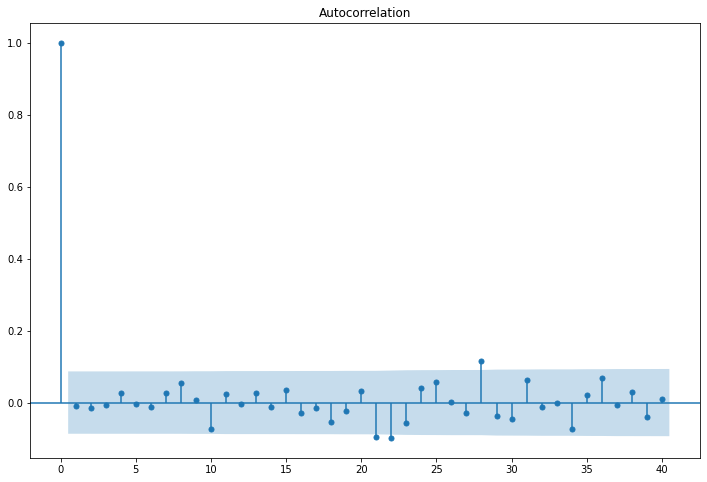

In [45]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax1)

## Test prediction on test subset

How good it is for in_sample prediciton

In [50]:
predict_ts3 = arima_model_fit.predict('2019-01', '2020-10', dynamic=False)

In [51]:
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()

In [52]:
mean_forecast_err(ts3, predict_ts3)

1.33951975555537

<AxesSubplot:>

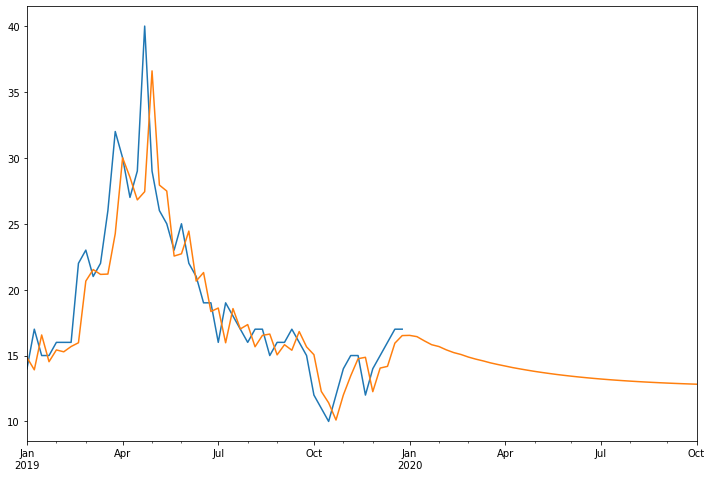

In [53]:
fig = plt.figure(figsize=[12,8])
ts3_train[ts3_train.index>'2019'].plot()
predict_ts3.plot()

## plot prediction

In [54]:
prediction = arima_model_fit.predict('2019', '2021', dynamic=False)

In [55]:
prediction.head(20)

2019-01-06    14.854792
2019-01-13    13.916920
2019-01-20    16.561215
2019-01-27    14.532101
2019-02-03    15.425704
2019-02-10    15.283881
2019-02-17    15.685024
2019-02-24    15.969843
2019-03-03    20.650246
2019-03-10    21.524705
2019-03-17    21.158070
2019-03-24    21.182299
2019-03-31    24.250559
2019-04-07    30.005573
2019-04-14    28.531172
2019-04-21    26.810704
2019-04-28    27.434890
2019-05-05    36.600718
2019-05-12    27.934513
2019-05-19    27.482678
Freq: W-SUN, dtype: float64

In [56]:
forecast = arima_model_fit.get_forecast(53)

In [57]:
forecast_mean = forecast.predicted_mean

In [96]:
forecast_conf_int = forecast.conf_int()

In [117]:
ts1[ts1.index==forecast_conf_int.index[0]][0]

301.0

In [118]:
np.ones(len(forecast_conf_int))*ts1[ts1.index==forecast_conf_int.index[0]][0]

array([301., 301., 301., 301., 301., 301., 301., 301., 301., 301., 301.,
       301., 301., 301., 301., 301., 301., 301., 301., 301., 301., 301.,
       301., 301., 301., 301., 301., 301., 301., 301., 301., 301., 301.,
       301., 301., 301., 301., 301., 301., 301., 301., 301., 301., 301.,
       301., 301., 301., 301., 301., 301., 301., 301., 301.])

In [119]:
np.ones(len(forecast_conf_int))*ts1[ts1.index==forecast_conf_int.index[0]][0]-forecast_conf_int.iloc[:,0]

2020-01-05    288.774549
2020-01-12    290.204540
2020-01-19    291.249675
2020-01-26    292.379381
2020-02-02    293.064675
2020-02-09    293.726379
2020-02-16    294.350017
2020-02-23    294.797643
2020-03-01    295.245051
2020-03-08    295.638439
2020-03-15    295.955283
2020-03-22    296.265208
2020-03-29    296.532382
2020-04-05    296.762963
2020-04-12    296.982169
2020-04-19    297.172118
2020-04-26    297.342133
2020-05-03    297.500349
2020-05-10    297.639371
2020-05-17    297.765939
2020-05-24    297.882288
2020-05-31    297.986009
2020-06-07    298.081103
2020-06-14    298.168069
2020-06-21    298.246514
2020-06-28    298.318626
2020-07-05    298.384526
2020-07-12    298.444484
2020-07-19    298.499664
2020-07-26    298.550170
2020-08-02    298.596399
2020-08-09    298.638981
2020-08-16    298.678055
2020-08-23    298.713966
2020-08-30    298.747079
2020-09-06    298.777543
2020-09-13    298.805623
2020-09-20    298.831546
2020-09-27    298.855451
2020-10-04    298.877533


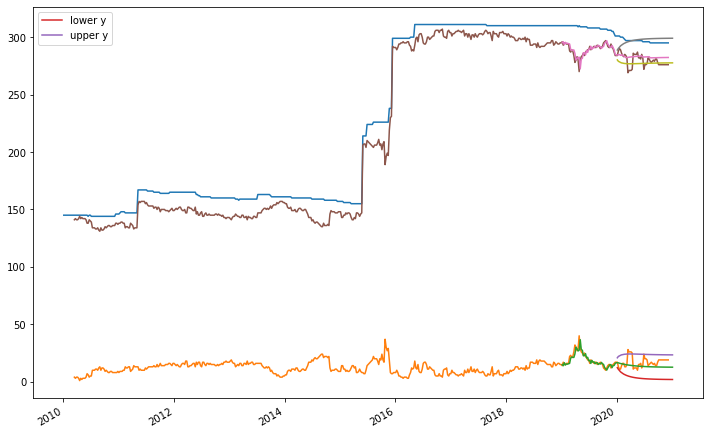

In [121]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(ts1[ts1.index>'2010'])
ts3.plot(ax=ax,grid=True)
prediction.plot(ax=ax)
forecast_conf_int.plot(ax=ax)
ax.plot(ts1-ts3)
# ax.plot(np.ones(len(forecast_conf_int))*ts1[ts1.index==forecast_conf_int.index[0]][0]-forecast_conf_int.iloc[:,0])
ax.plot(ts1-prediction)
ax.plot(np.ones(len(forecast_conf_int))*ts1[ts1.index==forecast_conf_int.index[0]][0]-forecast_conf_int.iloc[:,0])
ax.plot(np.ones(len(forecast_conf_int))*ts1[ts1.index==forecast_conf_int.index[0]][0]-forecast_conf_int.iloc[:,1])

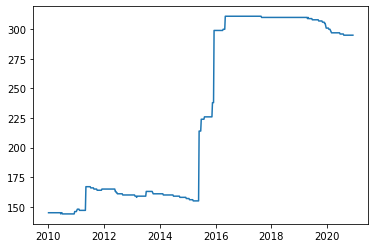

In [94]:
plt.plot(ts1[ts1.index>'2010'])

## AUTOARIMA ### 

## Find best arima parameters with autoarima

In [24]:
from pmdarima.arima import auto_arima

In [25]:
modelo_auto = auto_arima(ts3_train, m=52, trace=False)

Z:\anaconda3\envs\GETS_env3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
Z:\anaconda3\envs\GETS_env3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
Z:\anaconda3\envs\GETS_env3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
Z:\anaconda3\envs\GETS_env3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
Z:\anaconda3\envs\GETS_env3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization fail

In [32]:
modelo_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  512
Model:             SARIMAX(3, 0, 2)x(1, 0, [], 52)   Log Likelihood               -1127.747
Date:                             Tue, 01 Dec 2020   AIC                           2271.493
Time:                                     17:36:26   BIC                           2305.400
Sample:                                          0   HQIC                          2284.785
                                             - 512                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1423      0.602      3.560      0.000       0.963       3.322
ar.L1          0.0809      0.116      0.700      0.484      -0.146       0.308
ar.L2          0.2300      0.089      2.581      0.010       0.055       0.405
ar.L3          0.5351      0.133      4.011      0.000       0.274       0.797
ma.L1          0.7566      0.128      5.926      0.000       0.506       1.007
ma.L2          0.3828      0.160      2.396      0.017       0.070       0.696
ar.S.L52      -0.1082      0.044     -2.458      0.014      -0.194      -0.022
sigma2         4.7700      0.157     30.417      0.000       4.463       5.077
===================================================================================
Ljung-Box (Q):                       47.56   Jarque-Bera (JB):              3635.59
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               2.62   Skew:                             1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
modelo_auto2 = auto_arima(ts3_train, m=13, trace=False)

Z:\anaconda3\envs\GETS_env3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
Z:\anaconda3\envs\GETS_env3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
Z:\anaconda3\envs\GETS_env3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [33]:
modelo_auto2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  512
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -1130.332
Date:                Tue, 01 Dec 2020   AIC                           2274.665
Time:                        17:36:37   BIC                           2304.333
Sample:                             0   HQIC                          2286.295
                                - 512                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1145      0.573      3.687      0.000       0.990       3.239
ar.L1          0.0385      0.123      0.312      0.755      -0.203       0.280
ar.L2          0.2428      0.081      2.983      0.003       0.083       0.402
ar.L3          0.5504      0.133      4.138      0.000       0.290       0.811
ma.L1          0.8074      0.136      5.922      0.000       0.540       1.075
ma.L2          0.4114      0.157      2.620      0.009       0.104       0.719
sigma2         4.8243      0.146     32.970      0.000       4.538       5.111
===================================================================================
Ljung-Box (Q):                       45.37   Jarque-Bera (JB):              4683.25
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               2.60   Skew:                             1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
modelo_auto_nonseasonal = auto_arima(ts3_train, trace=False)

Z:\anaconda3\envs\GETS_env3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
Z:\anaconda3\envs\GETS_env3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [34]:
modelo_auto_nonseasonal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  512
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -1130.332
Date:                Tue, 01 Dec 2020   AIC                           2274.665
Time:                        17:36:54   BIC                           2304.333
Sample:                             0   HQIC                          2286.295
                                - 512                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1145      0.573      3.687      0.000       0.990       3.239
ar.L1          0.0385      0.123      0.312      0.755      -0.203       0.280
ar.L2          0.2428      0.081      2.983      0.003       0.083       0.402
ar.L3          0.5504      0.133      4.138      0.000       0.290       0.811
ma.L1          0.8074      0.136      5.922      0.000       0.540       1.075
ma.L2          0.4114      0.157      2.620      0.009       0.104       0.719
sigma2         4.8243      0.146     32.970      0.000       4.538       5.111
===================================================================================
Ljung-Box (Q):                       45.37   Jarque-Bera (JB):              4683.25
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               2.60   Skew:                             1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
import statsmodels.graphics.tsaplots as tsaplots

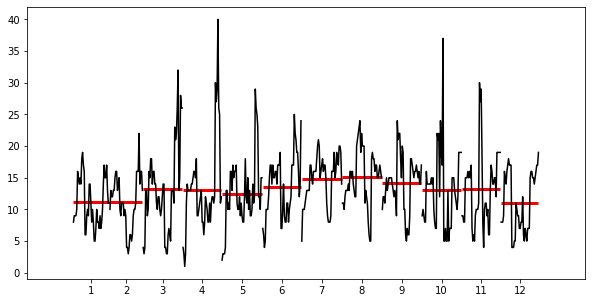

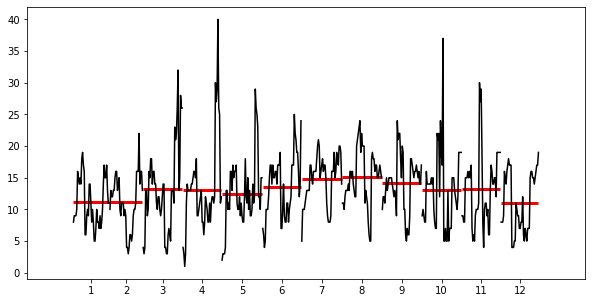

In [62]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(111)
tsaplots.seasonal_plot(ts3.groupby(ts3.index.month),
                       list(range(1,13)),ax=ax)

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [65]:
decomp = seasonal_decompose(ts3_train,period=13)

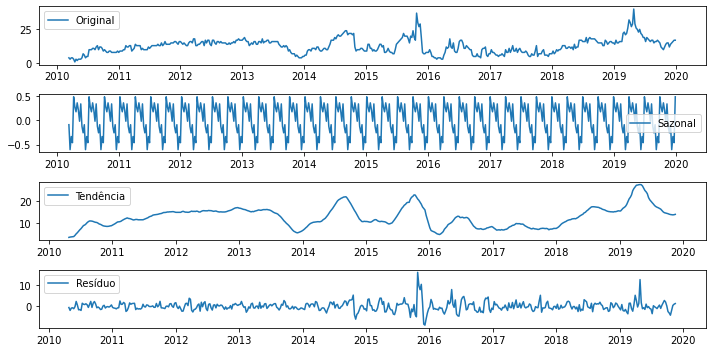

In [66]:
fig, ax = plt.subplots(4,1,figsize=[10,5])
ax[0].plot(ts3_train.index.get_level_values(0),ts3_train,label='Original')
ax[0].legend()
ax[1].plot(ts3_train.index.get_level_values(0),decomp.seasonal,label='Sazonal')
ax[1].legend()
ax[2].plot(ts3_train.index.get_level_values(0),decomp.trend,label='Tendência')
ax[2].legend()
ax[3].plot(ts3_train.index.get_level_values(0),decomp.resid,label='Resíduo')
ax[3].legend()
plt.tight_layout()

(array([0.00162946, 0.00814732, 0.06843746, 0.2264954 , 0.08799102,
        0.00977678, 0.00162946, 0.00162946, 0.00081473, 0.00081473]),
 array([-8.75898953, -6.30419352, -3.8493975 , -1.39460149,  1.06019452,
         3.51499054,  5.96978655,  8.42458256, 10.87937858, 13.33417459,
        15.78897061]),
 <BarContainer object of 10 artists>)

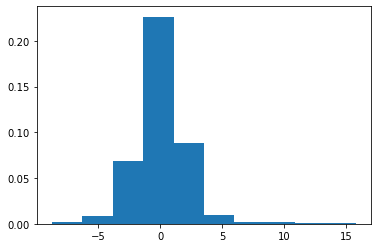

In [67]:
plt.hist(decomp.resid,density=True)

In [68]:
x = decomp.resid.values[~np.isnan(decomp.resid.values)]

In [69]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(x, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,230.11696,8.117625e-44


Significative, which means residues are different from white noise

LINKS: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html#Linking-Widgets
        aCHO QUE TEM  q por um observe pra atualizar algo na figura (interaction por exemplo)
        https://traitlets.readthedocs.io/en/stable/utils.html

            

In [1]:
import pmdarima

In [2]:
pmdarima.__version__

'1.7.1'

In [22]:
modelo_auto.summary()

AttributeError: 'AutoARIMA' object has no attribute 'model_'

In [22]:
modelo_auto2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  512
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -1130.332
Date:                Tue, 01 Dec 2020   AIC                           2274.665
Time:                        17:18:03   BIC                           2304.333
Sample:                             0   HQIC                          2286.295
                                - 512                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1145      0.573      3.687      0.000       0.990       3.239
ar.L1          0.0385      0.123      0.312      0.755      -0.203       0.280
ar.L2          0.2428      0.081      2.983      0.003       0.083       0.402
ar.L3          0.5504      0.133      4.138      0.000       0.290       0.811
ma.L1          0.8074      0.136      5.922      0.000       0.540       1.075
ma.L2          0.4114      0.157      2.620      0.009       0.104       0.719
sigma2         4.8243      0.146     32.970      0.000       4.538       5.111
===================================================================================
Ljung-Box (Q):                       45.37   Jarque-Bera (JB):              4683.25
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               2.60   Skew:                             1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
proximos12 = modelo_auto.predict(n_periods=12)

<IPython.core.display.Javascript object>


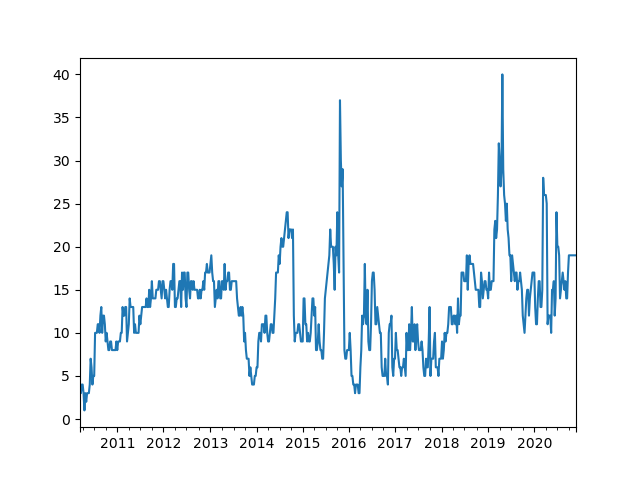

<AxesSubplot:>

In [45]:
ts3.plot()
# proximos12

## Apply arima to data

In [46]:
from statsmodels.tsa.arima_model import ARIMA

In [47]:
ts3_train = ts3[ts3.index<'2020']

<IPython.core.display.Javascript object>


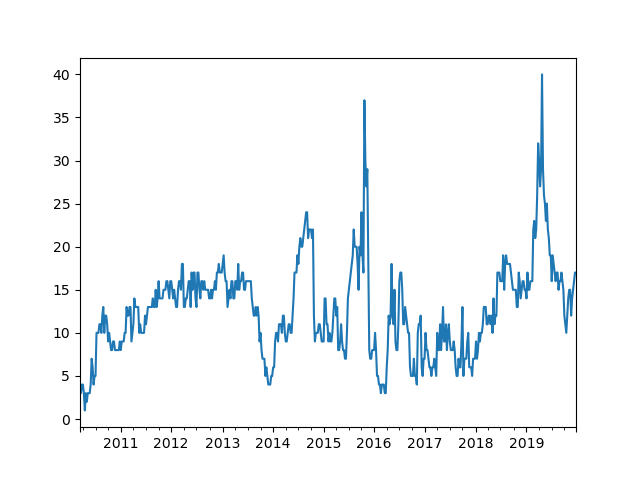

<AxesSubplot:>

In [48]:
ts3_train.plot()

In [55]:
model = ARIMA(ts3_train, order=(1,0,1))

In [56]:
model_fit = model.fit()

In [57]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  512
Model:                     ARMA(1, 1)   Log Likelihood               -1139.038
Method:                       css-mle   S.D. of innovations              2.234
Date:                Fri, 27 Nov 2020   AIC                           2286.076
Time:                        17:40:09   BIC                           2303.030
Sample:                    03-14-2010   HQIC                          2292.722
                         - 12-29-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5594      1.260      9.968      0.000      10.090      15.029
ar.L1.y        0.9340      0.018     53.089      0.000       0.900       0.968
ma.L1.y       -0.1356      0.052     -2.586      0.010      -0.238      -0.033
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0707           +0.0000j            1.0707            0.0000
MA.1            7.3752           +0.0000j            7.3752            0.0000
-----------------------------------------------------------------------------
"""

In [59]:
fig, ax = plt.subplots()
ax.plot(ts3.index,ts3.values)
fig = model_fit.plot_predict('2019', '2021', dynamic=False, ax=ax,plot_insample=False)

<IPython.core.display.Javascript object>

In [53]:
pred = model_fit.predict('2019', '2021', dynamic=False)

In [54]:
pred

2019-01-06    14.854749
2019-01-13    13.916998
2019-01-20    16.561220
2019-01-27    14.532125
2019-02-03    15.425715
                ...    
2020-12-06    12.701509
2020-12-13    12.691984
2020-12-20    12.683105
2020-12-27    12.674827
2021-01-03    12.667111
Freq: W-SUN, Length: 105, dtype: float64

In [49]:
idx1 = np.argwhere(xo1==pred.index[0])[0][0]
idx2 = np.argwhere(xo1[-1]==pred.index)[0][0]
print(idx1, idx2)

# pred.values[:idx2] = 

1514 97


In [73]:
np.array([[pred.values[idx2], pred.values[idx2]]])

array([[164.09771165, 164.09771165]])

<IPython.core.display.Javascript object>


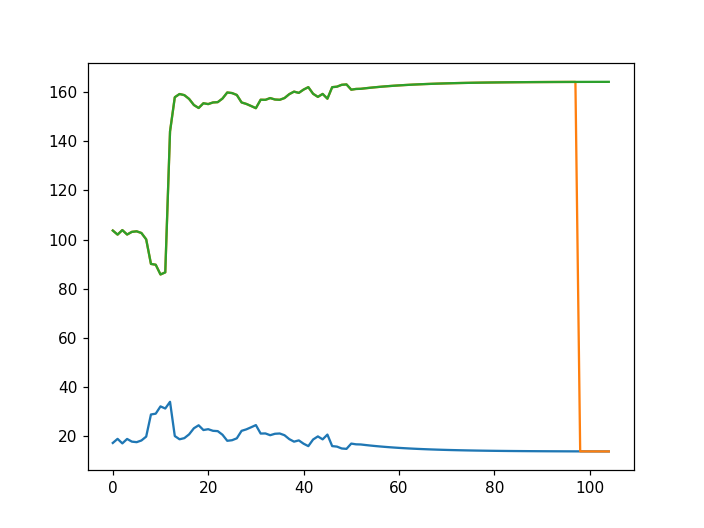

In [50]:
plt.plot(pred.values)
pred.values[:idx2+1] = yo1[idx1:] - pred.values[:idx2+1]
plt.plot(pred.values)
pred.values[idx2+1:] = yo1[-1] - pred.values[idx2+1:]
plt.plot(pred.values)

In [34]:
xo1[idx1:]

DatetimeIndex(['2019-01-06', '2019-01-13', '2019-01-20', '2019-01-27',
               '2019-02-03', '2019-02-10', '2019-02-17', '2019-02-24',
               '2019-03-03', '2019-03-10', '2019-03-17', '2019-03-24',
               '2019-03-31', '2019-04-07', '2019-04-14', '2019-04-21',
               '2019-04-28', '2019-05-05', '2019-05-12', '2019-05-19',
               '2019-05-26', '2019-06-02', '2019-06-09', '2019-06-16',
               '2019-06-23', '2019-06-30', '2019-07-07', '2019-07-14',
               '2019-07-21', '2019-07-28', '2019-08-04', '2019-08-11',
               '2019-08-18', '2019-08-25', '2019-09-01', '2019-09-08',
               '2019-09-15', '2019-09-22', '2019-09-29', '2019-10-06',
               '2019-10-13', '2019-10-20', '2019-10-27', '2019-11-03',
               '2019-11-10', '2019-11-17', '2019-11-24', '2019-12-01',
               '2019-12-08', '2019-12-15', '2019-12-22', '2019-12-29',
               '2020-01-05', '2020-01-12', '2020-01-19', '2020-01-26',
      

In [62]:
pd.date_range(start=pred.index[idx2+1], end=pred.index[-1], freq='W')

DatetimeIndex(['2020-11-22', '2020-11-29', '2020-12-06', '2020-12-13',
               '2020-12-20', '2020-12-27', '2021-01-03'],
              dtype='datetime64[ns]', freq='W-SUN')

In [ ]:
xo4 = copy.deepcopy(xo1)
yo4 = copy.deepcopy(yo1)
yo4[len(xo4)-len(xo3):] -= yo3

In [58]:
pred.index

DatetimeIndex(['2019-01-06', '2019-01-13', '2019-01-20', '2019-01-27',
               '2019-02-03', '2019-02-10', '2019-02-17', '2019-02-24',
               '2019-03-03', '2019-03-10',
               ...
               '2020-11-01', '2020-11-08', '2020-11-15', '2020-11-22',
               '2020-11-29', '2020-12-06', '2020-12-13', '2020-12-20',
               '2020-12-27', '2021-01-03'],
              dtype='datetime64[ns]', length=105, freq='W-SUN')

In [54]:
pred.index[idx2]

Timestamp('2020-11-22 00:00:00', freq='W-SUN')

<IPython.core.display.Javascript object>


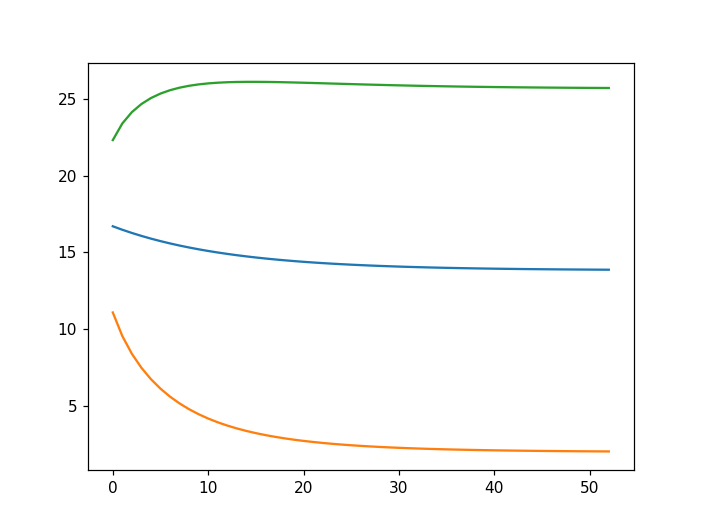

In [112]:
plt.plot(model_fit.forecast(53)[0])
plt.plot(model_fit.forecast(53)[2])

In [113]:
model_fit.conf_int()

,0,1
const,11.362848,16.299502
ar.L1.y,0.882839,0.959363
ma.L1.y,-0.292392,-0.103910


<IPython.core.display.Javascript object>


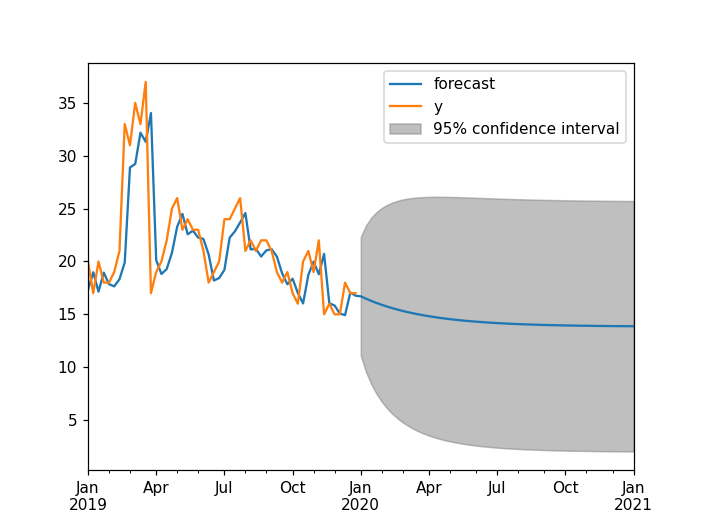

<IPython.core.display.Javascript object>


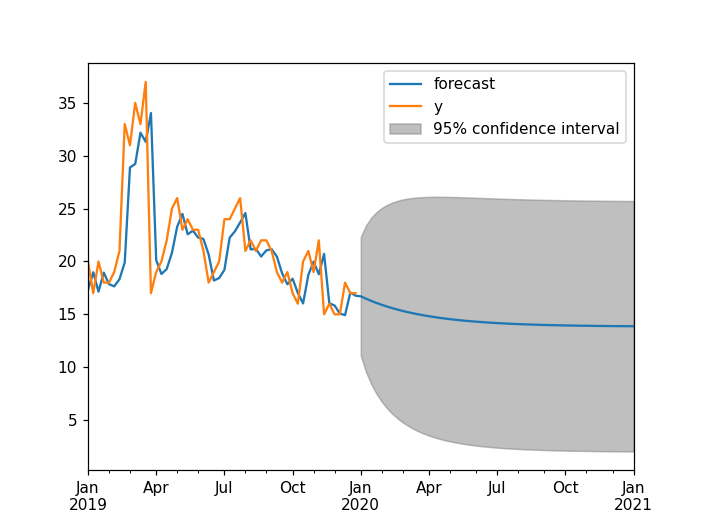

In [93]:
model_fit.plot_predict('2019','2021')

In [72]:
# modelo = ARIMA(ts1_monthly, order=(1,1,2),freq=ts1.index.inferred_freq)

modelo = ARIMA(ts3, order=(1,0,1))

In [73]:
modelo_treinado = modelo.fit()

In [74]:
modelo_treinado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  559
Model:                     ARMA(1, 1)   Log Likelihood               -1376.729
Method:                       css-mle   S.D. of innovations              2.837
Date:                Tue, 10 Nov 2020   AIC                           2761.458
Time:                        19:28:17   BIC                           2778.762
Sample:                    03-07-2010   HQIC                          2768.215
                         - 11-15-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.8557      1.147     12.076      0.000      11.607      16.104
ar.L1.y        0.9172      0.019     47.725      0.000       0.880       0.955
ma.L1.y       -0.1942      0.046     -4.216      0.000      -0.285      -0.104
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0903           +0.0000j            1.0903            0.0000
MA.1            5.1480           +0.0000j            5.1480            0.0000
-----------------------------------------------------------------------------
"""

In [75]:
a = modelo_treinado.forecast(steps=12)

<IPython.core.display.Javascript object>


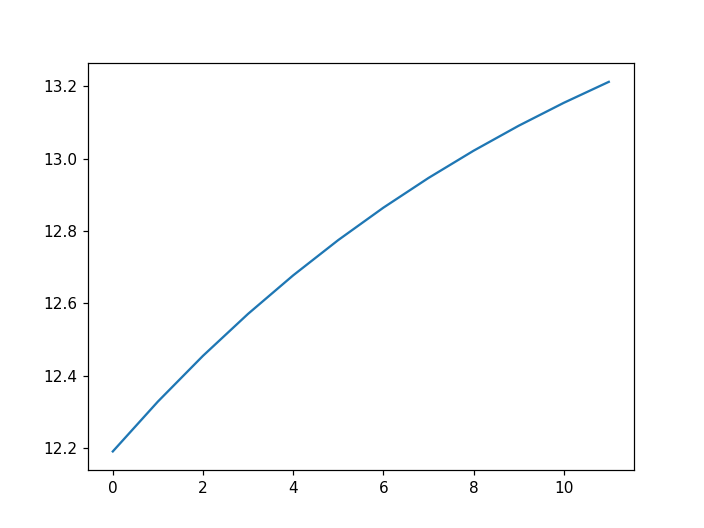

In [76]:
plt.plot(a[0])

<IPython.core.display.Javascript object>


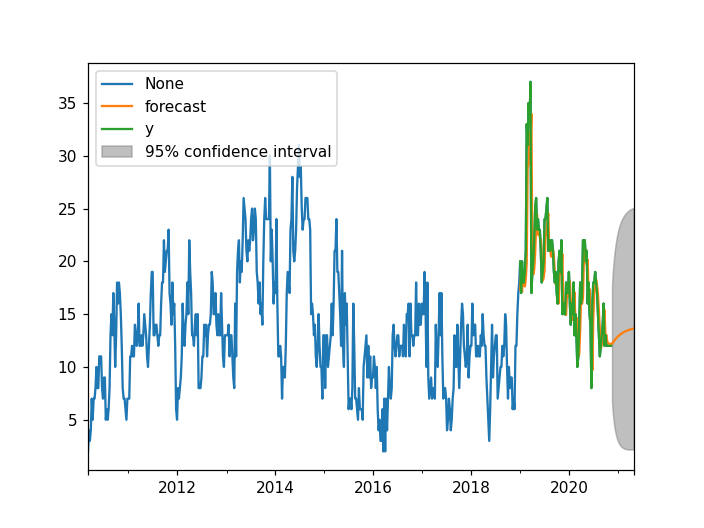

<IPython.core.display.Javascript object>


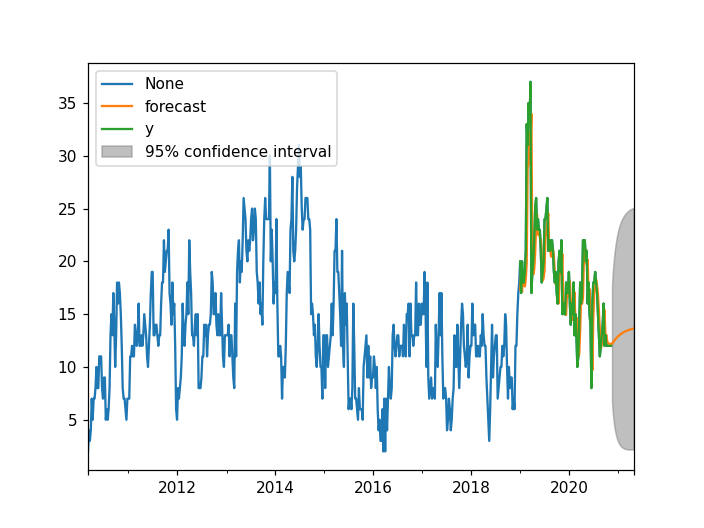

In [79]:
ax1 = ts3.plot()
modelo_treinado.plot_predict('2019','05-2021', ax=ax1, plot_insample=True)